# Resolución ejercicio 4.6.40
### Análisis y diseño de algoritmos distribuidos en redes
### Andrés Montoro 5.169.779-1



Exercise 4.6.40

Design an efficient protocol that, given a shortest-path spanning tree PT(s), determines an optimal swap for every edge in PT(s): At the end of the execution, every node x knows the optimal swap edge for its incident link e_s[x]. Your protocol should use no more than O(nh(s)) messages, where h(s) is the height of PT(x).

Se asumen las restricciones:
- BidirectionalLinks 
- Connectivity
- TotalReliability


AllBridges es un algoritmo propuesto en la bibliografía que haya, para cada arista e de cada nodo x, un swap edge optimal e'.

Definimos la clausura transitiva de PT(s) está definida como un grafo G' con los mismos nodos que G, pero que tiene una arista entre cada par de nodos para los cuales exista un camino entre ellos.

Observar que, en un árbol PT(s), la clausura transitiva PT'(s) tiene aristas para cada nodo x de acuerdo a las siguientes dos reglas:
- (1) Una arista con cada uno de sus ancestros: es decir, todos los nodos en el nivel i tienen una arista con cada uno de sus i ancestros directos.
- (2) Un arista con cada uno de sus descendientes: sin embargo, cualquier arista que cae en este caso ((x,y) donde y es descendiente de x) puede considerarse desde la perspectiva de (1): que el nodo y tiene una arista con su ancestro x.

Es decir, solo con la regla (1) ya tenemos todas las aristas de PT': hay una arista entre cada nodo y cada uno de sus ancestros.


Luego, podemos acotar brutamente la cantidad de aristas de PT'(s): si los n-1 nodos están en el nivel h(s) (lo cual no es real, debe haber nodos desde el nivel 1 hasta h(s)), entonces tenemos (n-1)*h(s) aristas, donde el nodo no considerado es s, que no tiene ancestros.


Por teorema 2 del paper, sabemos que AllBridges tiene una complejidad de is at most 2n∗ + n − 1, donde n* es es el numero de aristas en la clausura transitiva de PT(s). Sustituyendo con n* < (n-1)*h(s), tenemos:

M[All_Bridges] = 2n∗ + n − 1
                < 2 (n-1) h(s) + n − 1 =(n-1)(2 h(s) + 1) = O(n * h(s)), pues el resto son constantes.


No fue posible finalizar la implementación del algoritmo: observar que el método feasible no está implementado. No encontré una forma razonable de que cada nodo aprenda su α(a,b).

A su vez, se implementó PT_Construction de manera previa a AllBridges, de modo que se construya el PT antes.


In [ ]:
from pydistsim.algorithm.node_algorithm import NodeAlgorithm, StatusValues
from pydistsim.algorithm.node_wrapper import NodeAccess
from pydistsim.message import Message
from pydistsim.restrictions.communication import BidirectionalLinks
from pydistsim.restrictions.reliability import TotalReliability
from pydistsim.restrictions.topological import Connectivity
from pydistsim.restrictions.knowledge import InitialDistinctValues

from pydistsim import NetworkGenerator, Simulation
from pydistsim.logging import set_log_level, LogLevels, enable_logger
from pydistsim.network.behavior import NetworkBehaviorModel
from pydistsim.gui import drawing as draw
%matplotlib inline
from matplotlib import pyplot as plt


## Stages

### Implementacion

In [213]:
# By the start of AllBridges, every x should already know: 
#     Its children in Tr, 
#     Its parent in Tr, 
#     Its associated labels α(x) = (a, b) in Tr, 
#     Its neighbors in G.



class PTConstruction_AllBridges(NodeAlgorithm):
    default_params = {
        "Notify" : "Notify",
        "ack" : "ACK",
        "Expand" : "Expand",
        "IterationCompleted" : "IterationCompleted",
        "StartIteration" : "StartIteration",
        "MinValue" : "MinValue",
        "Terminate" : "Terminate",
        #####################
        "choice" : "Choice",
        "request" : "Request",
        "edge" : "Edge",
    }

    class Status(StatusValues):
        INITIATOR = "INITIATOR"
        IDLE = "IDLE"
        AWAKE = "AWAKE"
        WAITING_FOR_ACK = "WAITING_FOR_ACK"
        ACTIVE = "ACTIVE"
        PT_COMPUTING = "PT_COMPUTING"
        #######################
        COMPUTING = "COMPUTING" #DONE de PT
        SWAPPED = "SWAPPED"
        WAITING = "WAITING"

    S_init = (Status.INITIATOR, Status.IDLE)
    S_term = ()

    algorithm_restrictions = (
        BidirectionalLinks,
        Connectivity, 
        TotalReliability, 
        InitialDistinctValues
    )

    def costo(self, node: NodeAccess, neigh_id):
        # No encontre la forma de asociar costos
        return 1

    def error(self, method : str, message: Message):
        msj = 'Unexpected message in ' + method + message.header + " from " + str(message.source) + " , content: " + str(message.data)
        raise Exception(msj)
    
    def find_min(self, node: NodeAccess):
        z = None
        min = None
        for neigbhor in node.neighbors():
            if z is None and min is None:
                z = neigbhor
                min = self.costo(node, neigbhor)
            else:
                new_cost = self.costo(node, neigbhor)
                if new_cost < min:
                    z = neigbhor
                    min = new_cost
        # MIN{v(x, z) : z ∈ N(x)};
        return (min, z)

    def check_for_termination(self, node):
        if node.memory["minpath"] == float('inf'):
            self.send(
                node, 
                data=None,
                destination=node.memory["children"],
                header=self.default_params["Terminate"]
            )
            node.status = self.Status.COMPUTING
        else:
            self.send(
                node, 
                data=(node.memory["iteration"], node.memory["minpath"]),
                destination=[node.memory["exit"]],
                header=self.default_params["Expand"]
            )
            node.status = self.Status.ACTIVE
        
    def compute_local_minimum(self, node):
        if len(node.memory["unvisited"]) == 0:
            node.memory["minpath"] = float('inf')
        else:
            v, y = self.find_min(node)
            link_length = v
            node.memory["minpath"] = node.memory["my_distance"] + link_length
            node.memory["mychoice"] = node.memory["exit"] = y


    def feasible(self, edge, ab):
        #TODO
        a, b = ab
        return False

    def choose_min(self, node, ab_pair):
        candidatos = []
        for (edge, dist) in node.memory["L"]: 
            if self.feasible(edge, ab_pair):
                candidatos.append((edge, dist))
        if not candidatos:
            return (None, float("inf"))
        return min(candidatos, key=lambda e: e[1])


    def initializer(self):
        self.apply_restrictions()
        for node in self.network.nodes():
            node.status = self.Status.IDLE
            # PT_Construction
            node.memory["source"] = False
            node.memory["my_distance"] = None
            node.memory["ackcount"] = None
            node.memory["iteration"] = 0
            node.memory["childCount"] = None
            node.memory["unvisited"] = []
            node.memory["minpath"] = float('inf')
            #AllBridges
            node.memory["children"] = []
            node.memory["parent"] = None
            node.memory["check"] = 0
            node.memory["choice"] = {}
            node.memory["count"] = 0
            node.memory["swap"] = {}
            node.memory["ab"] = (0, 0)
        ini_node = self.network.nodes_sorted()[0]
        ini_node.push_to_inbox(Message(meta_header=NodeAlgorithm.INI, destination=ini_node))
        ini_node.status = self.Status.INITIATOR

 
############################################################################################################
############################################################################################################

    @Status.INITIATOR
    def spontaneously(self, node: NodeAccess, message: Message):
        node.memory["source"] = True
        node.memory["my_distance"] = 0
        node.memory["ackcount"] = len(node.neighbors())
        self.send(
            node, 
            data=None,
            destination=list(node.neighbors()),
            header=self.default_params["Notify"]
        )

    @Status.INITIATOR
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["ack"]:
            node.memory["ackcount"] -= 1
            if node.memory["ackcount"] == 0:
                node.memory["iteration"] = 1
                v,y = self.find_min(node)
                path_length = v
                node.memory["children"] = [y]
                self.send(
                    node, 
                    data=[node.memory["iteration"], path_length],
                    destination=[y],
                    header=self.default_params["Expand"]
                )
                node.memory["unvisited"] = set(node.neighbors()) - {y}
                node.status = self.Status.ACTIVE
        else:
            self.error("INITIATOR::receiving", message)


	
    @Status.IDLE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["Notify"]:
            node.memory["unvisited"] = set(node.neighbors()) - {message.source}
            self.send(
                node, 
                data=None,
                destination=message.source,
                header=self.default_params["ack"]
            )
            node.status = self.Status.AWAKE
        else:
            self.error("IDLE::receiving", message)
	
    @Status.AWAKE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["Expand"]:
            iteration_, path_value_ = message.data
            node.memory["my_distance"] = path_value_
            node.memory["parent"] = message.source
            node.memory["children"] = []
            if len(node.neighbors()) > 1:
                self.send(
                    node, 
                    data=None,
                    destination=list(set(node.neighbors()) - {message.source}),
                    header=self.default_params["Notify"]
                )
                node.memory["ackcount"] = len(node.neighbors()) - 1
                node.status = self.Status.WAITING_FOR_ACK
            else:
                self.send(
                    node, 
                    data=None,
                    destination=node.memory["parent"],
                    header=self.default_params["IterationCompleted"]
                )
                node.status = self.Status.ACTIVE
        elif message.header == self.default_params["Notify"]:
            node.memory["unvisited"].remove(message.source)
            self.send(
                node, 
                data=None,
                destination=message.source,
                header=self.default_params["ack"]
            )
        else:
            self.error("AWAKE::receiving", message)
      

    @Status.WAITING_FOR_ACK
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["ack"]:
            node.memory["ackcount"] -= 1
            if node.memory["ackcount"] == 0:
                self.send(
                    node, 
                    data=None,
                    destination=node.memory["parent"],
                    header=self.default_params["IterationCompleted"]
                )
                node.status = self.Status.ACTIVE
        else:
            self.error("WAITING_FOR_ACK::receiving", message)


    @Status.ACTIVE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["IterationCompleted"]:
            if not node.memory["source"]:
                self.send(
                    node, 
                    data=None,
                    destination=node.memory["parent"],
                    header=self.default_params["IterationCompleted"]
                )
            else:
                node.memory["iteration"] += 1
                self.send(
                    node, 
                    data=[node.memory["iteration"]],
                    destination=node.memory["children"],
                    header=self.default_params["StartIteration"]
                )
                self.compute_local_minimum(node)
                node.memory["childCount"] = 0
                node.status = self.Status.PT_COMPUTING
        
        elif message.header == self.default_params["StartIteration"]:
            iteration_ = message.data
            node.memory["iteration"] = iteration_
            self.compute_local_minimum(node)
            if len(node.memory["children"]) == 0:
                self.send(
                    node, 
                    data=node.memory["minpath"],
                    destination=node.memory["parent"],
                    header=self.default_params["MinValue"]
                )
            else:
                self.send(
                    node, 
                    data=node.memory["iteration"],
                    destination=node.memory["children"],
                    header=self.default_params["StartIteration"]
                )
                node.memory["childCount"] = 0
                node.status = self.Status.PT_COMPUTING

        elif message.header == self.default_params["Expand"]:
            iteration_, path_value_ = message.data
            self.send(
                    node, 
                    data=(iteration_, path_value_),
                    destination=node.memory["exit"],
                    header=self.default_params["Expand"]
            )
            if node.memory["exit"] == node.memory["mychoice"]:
                node.memory["children"].append(node.memory["mychoice"])
                node.memory["unvisited"].remove(node.memory["mychoice"])
                
        elif message.header == self.default_params["Notify"]:
            node.memory["unvisited"].remove(message.source)
            self.send(
                node, 
                data=None,
                destination=message.source,
                header=self.default_params["ack"]
            )

        elif message.header == self.default_params["Terminate"]:
            self.send(
                node, 
                data=None,
                destination=node.memory["children"],
                header=self.default_params["Terminate"]
            )
            node.status = self.Status.COMPUTING
        
        else:
            self.error("ACTIVE::receiving", message)

		
    @Status.PT_COMPUTING
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["MinValue"]:
            path_value_ = message.data
            if path_value_ < node.memory["minpath"]:
                node.memory["minpath"] = path_value_
                node.memory["exit"] = message.source
            node.memory["childCount"] += 1
            if node.memory["childCount"] == len(node.memory["children"]):
                if not node.memory["source"]:
                    self.send(
                        node, 
                        data=node.memory["minpath"],
                        destination=node.memory["parent"],
                        header=self.default_params["MinValue"]
                    )
                    node.status = self.Status.ACTIVE
                else:
                    self.check_for_termination(node)
                    
        else:
            self.error("PT_COMPUTING::receiving", message)




############################################################################################################
############################################################################################################
    @Status.COMPUTING
    def spontaneously(self, node: NodeAccess, message: Message):
        node.memory["count"] = 0
        if len(node.memory["children"]) == 0:
            mybridge, d = self.choose_min(node, node.memory["ab"])
            self.send(
                node, 
                data=(mybridge, d),
                destination=node.memory["parent"],
                header=self.default_params["choice"]
            )
            node.status = self.Status.SWAPPED

        else:
            # me quedo esperando receiving
            pass


    @Status.COMPUTING
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["choice"]:
            (edge, distance) = message.data
            if self.feasible(edge, node.memory["ab"]):
                node.memory["count"] += 1
                node.memory["choice"][message.source] = (edge, distance)
                if node.memory["count"] == len(node.memory["children"]):
                    mybridge, d = self.choose_min(node, node.memory["ab"])
                    self.send(
                        node,
                        data=(mybridge, d), 
                        destination=node.memory["parent"],
                        header=self.default_params["choice"]
                    )
                    node.status = self.Status.SWAPPED
            else:
                self.send(
                    node,
                    data= node.memory["ab"],
                    destination= message.source,
                    header= self.default_params["request"]
                )
        else:
            self.error("COMPUTING::receiving", message)


    @Status.SWAPPED
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["request"]:
            (p, q) = message.data
            edge, d = self.choose_min(node, (p, q))
            if len(node.memory["children"]) == 0:
                self.send(
                    node,
                    data= (edge, d),
                    destination= message.source,
                    header= self.default_params["choice"]
                )
            else:
                node.memory["check"] = 0
                for y in node.memory["children"]:
                    if not self.feasible(node.memory["swap"][y], (p,q)):
                        self.send(
                            node,
                            data= (p,q),
                            destination= y,
                            header= self.default_params["request"]
                        )
                        node.memory["check"] += 1
                    if node.memory["check"] > 0:
                        node.status = self.Status.WAITING
                    else:
                        (edge, d) = self.choose_min(node, (p,q))
                        self.send(
                            node,
                            data= (edge, d),
                            destination= list(node.memory["parent"]),
                            header= self.default_params["choice"]
                        )

        else:
            self.error("SWAPPED::receiving", message)

    @Status.WAITING
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == self.default_params["choice"]:
            (edge, distance) = message.data
            node.memory["choice"][message.source] = (edge, distance)
            check -= check
            if check == 0:
                (edge, d) = self.choose_min(node, node.memory["ab"])
                self.send(
                    node,
                    data=(edge, d), 
                    destination=node.memory["parent"],
                    header=self.default_params["choice"]
                )
                node.status = self.Status.SWAPPED

        else:
            self.error("WAITING::receiving", message)


### Ejecución


2025-11-10 16:59:39.292 | INFO     | pydistsim.simulation:__init__:59 - Simulation 0x204809d3b00 created successfully.


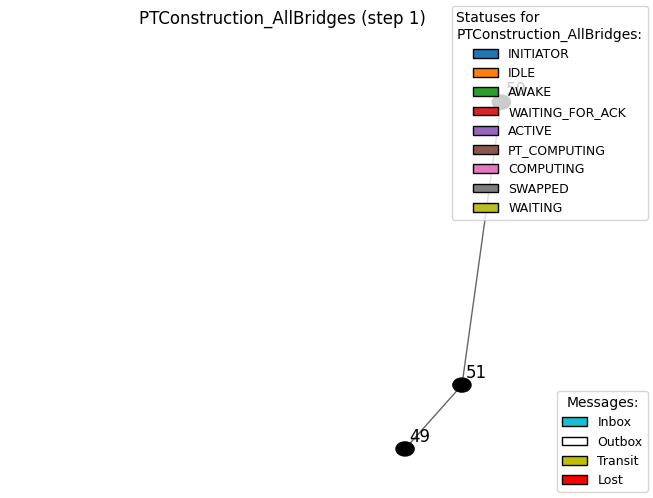

In [214]:
net_gen = NetworkGenerator(3, directed=False)
net = net_gen.generate_random_network()
sim = Simulation(net, check_restrictions=True)
sim.algorithms = (PTConstruction_AllBridges,)
set_log_level(LogLevels.INFO)
enable_logger()

fig = draw.draw_current_state(sim)
fig

In [235]:
sim.run(1)

fig = draw.draw_current_state(sim)
fig


KeyError: Neighbor(label=1)

## Otros

In [ ]:
sim.reset()
plt.close()